In [111]:
import pandas as pd
import numpy as np
import json
import re
import spacy
from nltk import ngrams, everygrams, bigrams

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'tagger'])

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

### Data

In [112]:
train = pd.read_json('train.json').set_index('id')

In [113]:
train

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...
29109,irish,"[light brown sugar, granulated sugar, butter, ..."
11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."


In [114]:
test = pd.read_json('test.json').set_index('id')

In [115]:
test

,ingredients
id,
18009,"[baking powder, eggs, all-purpose flour, raisi..."
28583,"[sugar, egg yolks, corn starch, cream of tarta..."
41580,"[sausage links, fennel bulb, fronds, olive oil..."
29752,"[meat cuts, file powder, smoked sausage, okra,..."
35687,"[ground black pepper, salt, sausage casings, l..."
...,...
30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
22339,"[black pepper, salt, parmigiano reggiano chees..."


In [116]:
with open('sample_submission.csv') as f:
    sample_submission = f.readlines()

In [117]:
len(sample_submission)

9945

In [118]:
sample_submission[:5]

['id,cuisine\n',
 '35203,italian\n',
 '17600,italian\n',
 '35200,italian\n',
 '17602,italian\n']

### Feature engineering

In [119]:
def clean_ingredients(old_ing):
    ing = old_ing.lower()
    ing = re.sub(r'\(.*oz\.\)', ' ', ing)
    ing = re.sub(r'[^a-zâçèéíîú]', ' ', ing)
    ing = re.sub(r' +', ' ', ing)
    ing = ing.strip()
    return ing

In [120]:
train['ingredients'] = train['ingredients'].apply(lambda x: [clean_ingredients(ing) for ing in x])
test['ingredients'] = test['ingredients'].apply(lambda x: [clean_ingredients(ing) for ing in x])

In [121]:
def lemmatize(old_ing):
    doc = nlp(old_ing)
    return ' '.join([token.lemma_ for token in doc])

In [122]:
train['norm'] = train['ingredients'].apply(lambda x: [lemmatize(ing) for ing in x])
test['norm'] = test['ingredients'].apply(lambda x: [lemmatize(ing) for ing in x])

In [123]:
train['words'] = train['norm'].apply(lambda x: ' '.join(x))
test['words'] = test['norm'].apply(lambda x: ' '.join(x))

In [124]:
def get_bigrams(l: list):
    ngrams_list = []
    for item in l:
        if ' ' not in item:
            ngrams_list.append(item)
        else:
            ngrams_list += ['_'.join(pair) for pair in bigrams(item.split())]
    return ' '.join(ngrams_list)

In [125]:
train['bigrams'] = train['norm'].apply(lambda x: get_bigrams(x))
test['bigrams'] = test['norm'].apply(lambda x: get_bigrams(x))

In [126]:
train

,cuisine,ingredients,norm,words,bigrams
id,,,,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olive, grape tomato, g...",romaine lettuce black olive grape tomato garli...,romaine_lettuce black_olive grape_tomato garli...
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, grind pepper, salt, tomato, grin...",plain flour grind pepper salt tomato grind bla...,plain_flour grind_pepper salt tomato grind_bla...
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[egg, pepper, salt, mayonaise, cook oil, green...",egg pepper salt mayonaise cook oil green chili...,egg pepper salt mayonaise cook_oil green_chili...
22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,water vegetable_oil wheat salt
13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallot, cornflour, cayenne pep...",black pepper shallot cornflour cayenne pepper ...,black_pepper shallot cornflour cayenne_pepper ...
...,...,...,...,...,...
29109,irish,"[light brown sugar, granulated sugar, butter, ...","[light brown sugar, granulate sugar, butter, w...",light brown sugar granulate sugar butter warm ...,light_brown brown_sugar granulate_sugar butter...
11462,italian,"[kraft zesty italian dressing, purple onion, b...","[kraft zesty italian dress, purple onion, broc...",kraft zesty italian dress purple onion broccol...,kraft_zesty zesty_italian italian_dress purple...
2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[egg, citrus fruit, raisin, sourdough starter,...",egg citrus fruit raisin sourdough starter flou...,egg citrus_fruit raisin sourdough_starter flou...


In [17]:
#c_vectorizer_counts = CountVectorizer()
#c_vectorizer_bin = CountVectorizer(binary=True)
#c_vectorizer_counts_bigram = CountVectorizer(token_pattern=r'(?u)\b\w+_?\w+\b')
#c_vectorizer_bin_bigram = CountVectorizer(token_pattern=r'(?u)\b\w+_?\w+\b', binary=True)
#tfidf = TfidfVectorizer()
tfidf_bin = TfidfVectorizer(binary=True)
#tfidf_bigram = TfidfVectorizer(token_pattern=r'(?u)\b\w+_?\w+\b')
#tfidf_bin_bigram = TfidfVectorizer(token_pattern=r'(?u)\b\w+_?\w+\b', binary=True)

In [18]:
X = tfidf_bin.fit_transform(train['words'])
X_kaggle = tfidf_bin.transform(test['words'])

In [19]:
print(X.shape)
print(X_kaggle.shape)

(39774, 2692)
(9944, 2692)


In [20]:
y = train['cuisine']
y

id
10259          greek
25693    southern_us
20130       filipino
22213         indian
13162         indian
            ...     
29109          irish
11462        italian
2238           irish
41882        chinese
2362         mexican
Name: cuisine, Length: 39774, dtype: object

### SVC

In [164]:
X_train, X_test, y_train, y_test = train_test_split(train['words'], y, test_size=8000, random_state=10)

In [165]:
pipe = Pipeline([('tfidf', TfidfVectorizer(binary=True)),
               ('svc', SVC(max_iter=10000, random_state=10))])

In [166]:
%%time
pipe.fit(X_train, y_train)

Wall time: 2min 1s


SVC(max_iter=10000, random_state=10)

In [167]:
%%time
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

Wall time: 2min 34s


In [168]:
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.928463523635677
0.804


|Type of data|Accuracy Train|Accuracy Test|Cross-val score|
|:-|:-:|:-:|:-:|
|Counts for words|0.87565|0.78413|
|Binary for words|0.88557|0.78638|
|Counts for bigrams|0.89668|0.766|
|Binary for bigrams|0.89765|0.7675|
|Tfidf for words|0.92610|0.8035|0.80027|
|<span style="color:blue">Binary tfidf for words</span>|<span style="color:blue">0.92837</span>|<span style="color:blue">0.804</span>|<span style="color:blue">0.80067</span>|
|Binary tfidf for words, l1 norm|0.92588|0.79625|
|Tfidf for bigrams|0.94341|0.786|
|Binary tfidf for bigrams|0.94392|0.78813|

In [150]:
cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

0.8006738779408374

### Size of recipe

In [101]:
train['size'] = train['ingredients'].apply(lambda x: len(x))
test['size'] = test['ingredients'].apply(lambda x: len(x))

In [102]:
train[['size']].describe()

,size
count,39774.000000
mean,10.767713
std,4.428978
min,1.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,65.000000


In [87]:
test[['size']].describe()

,size
count,9944.000000
mean,10.799980
std,4.467154
min,1.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,50.000000


<AxesSubplot:xlabel='size'>

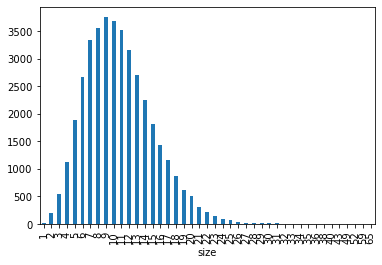

In [88]:
train.groupby('size').size().plot.bar()

<AxesSubplot:xlabel='size'>

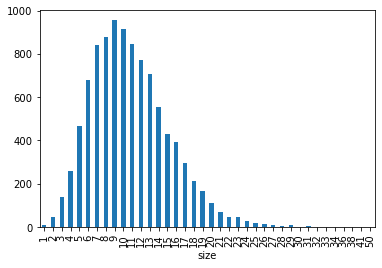

In [89]:
test.groupby('size').size().plot.bar()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['cuisine'], axis=1), train['cuisine'], test_size=8000, random_state=10)

In [104]:
X_train_small = X_train[X_train['size'] > 6]['words']
X_train_small

id
45173    tomato evaporate cane juice garlic grind turme...
35603    can low sodium chicken broth asparagus garlic ...
38910    sugar eggplant coarse salt red bell pepper wat...
7417     grind ginger dry roast peanut rice wine crush ...
31551    tofu peanut chop garlic sweet chili sauce cila...
                               ...                        
27635    sugar peel fresh ginger all purpose flour grin...
4818     pepper bake soda onion powder all purpose flou...
28937    black pepper vegetable oil beef all purpose fl...
32059    red chili powder cilantro leave bay leaf cleav...
3162     crawfish butter onion salt and grind black pep...
Name: words, Length: 26618, dtype: object

In [105]:
y_train_small = y_train[X_train_small.index]

In [106]:
X_test = X_test['words']

In [107]:
pipe = Pipeline([('tfidf', TfidfVectorizer(binary=True)),
               ('svc', SVC(max_iter=10000, random_state=10))])

In [108]:
%%time
pipe.fit(X_train_small, y_train_small)

Wall time: 1min 28s


Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True)),
                ('svc', SVC(max_iter=10000, random_state=10))])

In [109]:
%%time
pred_train = pipe.predict(X_train_small)
pred_test = pipe.predict(X_test)

Wall time: 2min 1s


In [110]:
print(accuracy_score(y_train_small, pred_train))
print(accuracy_score(y_test, pred_test))

0.9391013599819671
0.794375


|Size of recipe|Accuracy Train|Accuracy Test|Cross-val score|
|:-:|:-:|:-:|:-:|
|>0|0.92837|0.804|0.80067|
|>1|0.9289|0.80438|
|>2|0.92978|0.804|
|>3|0.93043|0.80463|
|>4|0.93146|0.80288|
|>5|0.93474|0.79863|
|>6|0.9391|0.79438|

In [ ]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

Removing recipes that consist of few ingredients is unlikely to affect the score.

### Hyperparam tuning for SVC

As SVC takes much time to fit and predict, the hyperparams got tuned one by one:
* kernel='rbf' (default)
* C=3
* class_weight=None (default)
* gamma='scale' (default)

In [175]:
def get_best_model(model, X_tr, y_tr, param_grid):
    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid.fit(X_tr, y_tr)
    
    return grid.best_estimator_, grid.best_score_, grid.best_params_, pd.DataFrame(grid.cv_results_)

In [176]:
pipe = Pipeline([('tfidf', TfidfVectorizer(binary=True)),
               ('svc', SVC(C=3, kernel='rbf', max_iter=10000, random_state=10))])

In [177]:
params = {'svc__gamma': ['scale', 'auto']}

In [178]:
model_data = get_best_model(pipe, train['words'], train['cuisine'], params)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [179]:
for item in model_data[:3]:
    print(item)

Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True)),
                ('svc', SVC(C=3, max_iter=10000, random_state=10))])
0.8053250867400813
{'svc__gamma': 'scale'}


In [182]:
model_data[3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,85.331801,0.725423,46.334665,0.069562,scale,{'svc__gamma': 'scale'},0.804194,0.805099,0.806683,0.805325,0.001029,1
1,153.101734,0.327214,62.646060,0.130292,auto,{'svc__gamma': 'auto'},0.285262,0.284658,0.283527,0.284482,0.000719,2


### SVC with best params

In [183]:
X_train, X_test, y_train, y_test = train_test_split(train['words'], train['cuisine'], test_size=8000, random_state=10)

In [184]:
pipe = Pipeline([('tfidf', TfidfVectorizer(binary=True)),
               ('svc', SVC(C=3, max_iter=10000, random_state=10))])

In [185]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True)),
                ('svc', SVC(C=3, max_iter=10000, random_state=10))])

In [186]:
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

In [187]:
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.9946497136023164
0.81125


In [188]:
cross_val_score(pipe, train['words'], train['cuisine'], cv=5, scoring='accuracy').mean()

0.8103535713760787

Cross-validation score: 0.81

### Kaggle submission

In [194]:
pipe = Pipeline([('tfidf', TfidfVectorizer(binary=True)),
               ('svc', SVC(C=3, max_iter=15000, random_state=10))])

In [195]:
pipe.fit(train['words'], train['cuisine'])

Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True)),
                ('svc', SVC(C=3, max_iter=15000, random_state=10))])

In [196]:
pred_kaggle = pipe.predict(test['words'])
pred_kaggle

array(['british', 'southern_us', 'italian', ..., 'italian', 'southern_us',
       'mexican'], dtype=object)

In [197]:
submission = pd.DataFrame(pred_kaggle, index=test.index, columns=['cuisine'])
submission

,cuisine
id,
18009,british
28583,southern_us
41580,italian
29752,cajun_creole
35687,italian
...,...
30246,french
36028,southern_us
22339,italian


In [198]:
submission.to_csv('submission8.csv')

Kaggle score: 0.81114